
<div dir=”rtl”>

</div>

<div style="text-align: right; direction: rtl;">
در این چالش قصد داریم با توجه به تصویری از یک صفحه شطرنج، نحوه قرار گیری مهره ها در صفحه را تشخیص دهیم. در این چالش برای بازنمایی نحوه قرار گیری مهره ها از استاندارد FEN (Forsyth–Edwards Notation) استفاده می‌کنیم.
</div>

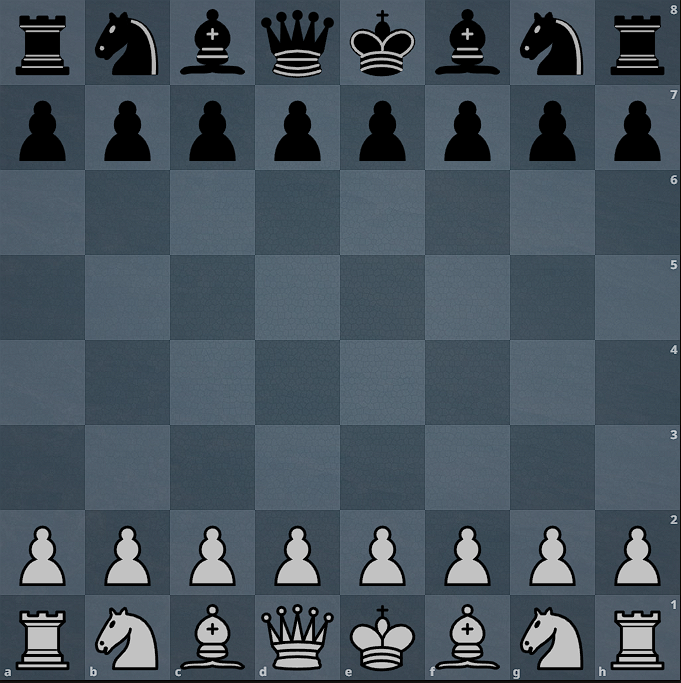

rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1

In [108]:
!cp /content/drive/MyDrive/Colab\ Notebooks/model_utils.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/train.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/predict_utils.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/vis_utils.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/build_vocab.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/data_loader.py /content

In [109]:
!cp /content/drive/MyDrive/Colab\ Notebooks/model_utils.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/train.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/predict_utils.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/vis_utils.py /content

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [110]:
# ! gdown --id 1GC7qe9xTPjPAlQmZQPMdYjROgVNAmYWD
# ! unzip Problem03.zip

In [111]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms as transforms
import torchvision.models as models

# from utils import *
from build_vocab import build_vocab
from data_loader import get_loader

# setup
use_gpu = torch.cuda.is_available()

In [112]:
use_gpu

True

In [113]:
def load_cnn_model(model_name, pretrained=True):
    "Load and return a convolutional neural network."
    assert model_name in ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']
    return models.__dict__[model_name](pretrained)


def load_image(image_path, transform=None):
    "Load an image and perform given transformations."
    image = Image.open(image_path)    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

In [114]:
vocab = build_vocab()

In [115]:
for i in range(16):
    print("%s --> %d" %(vocab.idx2word[i], i))

<PAD> --> 0
<BOS> --> 1
<EOS> --> 2
<UNK> --> 3
K --> 4
k --> 5
N --> 6
n --> 7
p --> 8
P --> 9
Q --> 10
q --> 11
- --> 12
B --> 13
b --> 14
R --> 15


In [116]:
images_dir = '/content/Problem03/train'
image_size = 128
crop_size  = 128
batch_size = 16


transform = transforms.Compose([
    transforms.Resize(image_size),
    #transforms.RandomCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

In [117]:
data_loader = get_loader(images_dir, vocab, 
                         transform, batch_size, 
                         shuffle=True, num_workers=0)

In [118]:
imgs, caps, lengths = next(iter(data_loader))


print(" ".join([str(id) for id in caps[0][1:-1]]))

print(" ".join([vocab.idx2word[int(id)] for id in caps[0][1:-1]]))

tensor(16) tensor(7) tensor(14) tensor(17) tensor(5) tensor(19) tensor(12) tensor(8) tensor(18) tensor(8) tensor(17) tensor(8) tensor(11) tensor(17) tensor(12) tensor(20) tensor(8) tensor(18) tensor(16) tensor(12) tensor(17) tensor(8) tensor(18) tensor(9) tensor(19) tensor(12) tensor(18) tensor(8) tensor(9) tensor(18) tensor(7) tensor(17) tensor(12) tensor(18) tensor(9) tensor(13) tensor(17) tensor(6) tensor(18) tensor(12) tensor(9) tensor(9) tensor(6) tensor(10) tensor(18) tensor(9) tensor(9) tensor(12) tensor(15) tensor(19) tensor(4) tensor(18) tensor(15)
r n b 1 k 3 - p 2 p 1 p q 1 - 4 p 2 r - 1 p 2 P 3 - 2 p P 2 n 1 - 2 P B 1 N 2 - P P N Q 2 P P - R 3 K 2 R


In [119]:

import torch.nn.functional as F
class EncoderCNN(nn.Module):
    def __init__(self, model_name, embed_size):
   
        super(EncoderCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2) #64
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2) #32
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
           nn.MaxPool2d(2) #16
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
           nn.MaxPool2d(2) #8
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)  #4
        )
        
       
        self.linear = nn.Linear(4 * 4 * 256, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)


    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)  # flatten
        out = F.relu(self.linear(out))
        out = self.bn(out)
        return out



  

In [120]:
class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, tie_weights):
        super(DecoderLSTM, self).__init__()
        
        if tie_weights:
            embed_size = hidden_size
            
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.35)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(p=dropout)
        
        if tie_weights:
            # share weights between embedding and classification layer
            self.fc.weight = self.embedding.weight
            
        self.init_weights()
        
    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        
    def forward(self, features, captions, lengths):
        x = self.embedding(captions)
        x = torch.cat([features.unsqueeze(1), x], dim=1)
        x = self.dropout(x)
        x = pack_padded_sequence(x, lengths, batch_first=True)
        x, _ = self.lstm(x)
        x = self.dropout(x[0])
        x = self.fc(x)
        return x
    
    def sample(self, features, states=None):
        """Samples captions for given image features (Greedy search)."""
        sampled_ids = []
        inputs = features.unsqueeze(1)

        for i in range(64):                                      # maximum sampling length
            hiddens, states = self.lstm(inputs, states)          # (batch_size, 1, hidden_size), 
            outputs = self.fc(hiddens.squeeze(1))                # (batch_size, vocab_size)
            token_id = outputs.max(1)[1]
            sampled_ids += [token_id]
            inputs = self.embedding(token_id)
            inputs = inputs.unsqueeze(1)                         # (batch_size, 1, embed_size)
        sampled_ids = torch.cat(sampled_ids, 0)                  # (batch_size, 20)
        return sampled_ids.squeeze()

In [121]:
class EncoderDecoder(nn.Module):
    
    def __init__(self, cnn_name, vocab_size, embed_size, hidden_size, num_layers, dropout, tie_weights):
        super(EncoderDecoder, self).__init__()
        
        if tie_weights:
            embed_size = hidden_size
            
        self.encoder = EncoderCNN(cnn_name, embed_size)
        self.decoder = DecoderLSTM(vocab_size, embed_size, hidden_size, num_layers, dropout, tie_weights)
        
        # create output folder to save weights
        self.save_path = f'{cnn_name}-{embed_size}-{hidden_size}-{num_layers}'
        if not os.path.exists(self.save_path):
            os.mkdir(self.save_path)
    
    def forward(self, images, captions, lengths):
        features = self.encoder(images)
        outputs = self.decoder(features, captions, lengths)
        return outputs
    
    def save(self, epoch, loss):
        torch.save({'encoder': self.encoder.state_dict(), 
                    'decoder': self.decoder.state_dict()}, f'{self.save_path}/{epoch}-{loss:.2f}.pth')
    
    def load(self, epoch):
        model_path = glob(f'{self.save_path}/{epoch}-*.pth')[-1]
        try:
            d = torch.load(model_path)
            self.encoder.load_state_dict(d['encoder'])
            self.decoder.load_state_dict(d['decoder'])
        except:
            print('Invalid epoch number <{}>, the model does not exist!'.format(epoch))

In [122]:
# model hyper-parameters
cnn_name = 'resnet101'
embed_size  = 1024
hidden_size = 1024
num_layers  = 2
tie_weights = True

# training hyper-parameters
start_epoch = 0
num_epochs  = 20
learning_rate = 0.001

In [123]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [124]:
def train_epoch(model, train_dl, criterion, optimizer, scheduler, epoch, last_epoch):
    model.encoder.train()
    model.decoder.train()
    scheduler.step()
    
    total_steps = len(train_dl)
    epoch_loss = 0.0
    
    for i, (images, captions, lengths) in enumerate(train_dl):
        images, captions = images.to(device), captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
        # forward step
        outputs = model(images, captions, lengths)
        loss = criterion(outputs, targets)
        epoch_loss = (epoch_loss * i + loss.item()) / (i + 1)
        
        # backward step
        model.encoder.zero_grad()
        model.decoder.zero_grad()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.decoder.parameters(), 5.0)
        optimizer.step()
        
        # report log info
        sys.stdout.flush()
        sys.stdout.write('\rEpoch [%2d/%2d], Step [%3d/%3d], Loss = %.4f, Perplexity = %.4f    '
                         % (epoch+1, last_epoch, i+1, total_steps, epoch_loss, np.exp(epoch_loss)))
    print()

    return epoch_loss


def train(model, train_dl, criterion, optimizer, scheduler, start_epoch=0, num_epochs=10):
    last_epoch = start_epoch + num_epochs
        
    for epoch in range(start_epoch, last_epoch):                
        # train step
        trn_loss = train_epoch(model, data_loader, criterion, optimizer, scheduler, epoch, last_epoch)
        
        # save model
        model.save(epoch, trn_loss)

In [125]:
model = EncoderDecoder(cnn_name, len(vocab), embed_size, hidden_size, num_layers, 0.3, tie_weights)
if use_gpu:
    model = model.cuda()

In [126]:
use_gpu

True

In [127]:
# loss function
criterion = nn.CrossEntropyLoss()
if use_gpu:
    criterion = criterion.cuda()
  
# list of parameters which will be updated
params = list(model.decoder.parameters())
params += list(model.encoder.parameters()) 


# optimizer
optimizer = torch.optim.RMSprop(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)

we


In [129]:
train(model, data_loader, criterion, optimizer, scheduler, start_epoch, num_epochs=10)

Epoch [ 1/10], Step [  1/1126], Loss = 0.1265, Perplexity = 1.1349    

<ipython-input-124-9ccd963b1ee5>:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.decoder.parameters(), 5.0)


Epoch [ 1/10], Step [1126/1126], Loss = 0.1693, Perplexity = 1.1844    
Epoch [ 2/10], Step [1126/1126], Loss = 0.1636, Perplexity = 1.1777    
Epoch [ 3/10], Step [1126/1126], Loss = 0.1568, Perplexity = 1.1697    
Epoch [ 4/10], Step [1126/1126], Loss = 0.1502, Perplexity = 1.1621    
Epoch [ 5/10], Step [1126/1126], Loss = 0.1444, Perplexity = 1.1553    
Epoch [ 6/10], Step [1126/1126], Loss = 0.1396, Perplexity = 1.1499    
Epoch [ 7/10], Step [1126/1126], Loss = 0.1348, Perplexity = 1.1443    
Epoch [ 8/10], Step [1126/1126], Loss = 0.1281, Perplexity = 1.1366    
Epoch [ 9/10], Step [1126/1126], Loss = 0.1240, Perplexity = 1.1321    
Epoch [10/10], Step [1126/1126], Loss = 0.1195, Perplexity = 1.1270    


In [130]:
from PIL import Image

val_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

In [135]:
def generate_caption(model, img_filenames):
    model.encoder.eval()
    model.decoder.eval()
    
    captions = []
    
    for img_filename in img_filenames:

        # prepare test image
        image = load_image(img_filename, val_transform)
        image_tensor = image.to(device)

        # Generate features from image
        feature = model.encoder(image_tensor)

        # Generate caption from image
        sampled_ids = model.decoder.sample(feature)
        sampled_ids = sampled_ids.cpu().data.numpy()

        # decode word ids to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            if word == '<EOS>': break
            sampled_caption.append(word)

        caption = "".join(sampled_caption[1:])
        captions.append((img_filename, caption))
    
    return captions

In [132]:
img_filenames = glob('/content/Problem03/train/*.png')[:10] 
captions = generate_caption(model, img_filenames)

for img, caption in captions:
    display((caption, img))

('8 - 1 p p 1 p p 2 - p 7 - 3 P k 3 - 1 P 5 P - P 5 R 1 - 6 P 1 - 6 K 1',
 '/content/Problem03/train/8-1pp1pp2-p7-3Pk3-1P5P-P5R1-6P1-6K1.png')

('r 1 b 1 k 2 r - 5 p p p - p 2 q p 3 - 3 p 4 - 8 - 5 N 2 - P P 3 P P P - R 2 Q R 1 K 1',
 '/content/Problem03/train/r1b1k2r-5ppp-p2qp3-3p4-8-5N2-PP3PPP-R2QR1K1.png')

('r 4 r k 1 - p p q 2 p p p - 5 n 2 - 3 P 1 P 2 - 3 P 1 b 2 - 1 B 5 Q - P P 2 p 1 P P - R N 2 R 1 K 1',
 '/content/Problem03/train/r4rk1-ppq2ppp-5n2-3P1P2-3P1b2-1B5Q-PP2p1PP-RN2R1K1.png')

('1 k 2 r 3 - p p p 5 - 3 p N 3 - 1 P 1 n p 2 p - P 5 p P - B 1 b 2 r P 1 - 2 R 4 K - 2 R 5',
 '/content/Problem03/train/1k2r3-ppp5-3pN3-1P1np2p-P5pP-B1b2rP1-2R4K-2R5.png')

('6 k 1 - p 1 p 3 p 1 - 1 p 4 p 1 - 4 P 3 - 5 P 2 - 1 P P 5 - P 6 P - R 5 K 1',
 '/content/Problem03/train/6k1-p1p3p1-1p4p1-4P3-5P2-1PP5-P6P-R5K1.png')

('8 - 4 b 1 k p - 5 p 2 - 4 p P p 1 - 1 P p 1 P 1 P 1 - n 1 P 1 B 2 P - Q 3 B K 2 - 7 q',
 '/content/Problem03/train/8-4b1kp-5p2-4pPp1-1Pp1P1P1-n1P1B2P-Q3BK2-7q.png')

('r r 4 k 1 - p b p q 1 p b p - 6 p 1 - 2 P p 2 n 1 - 1 P 1 P 4 - 2 N 1 P P 2 - P B Q 3 P P - R 1 B 1 R 1 K 1',
 '/content/Problem03/train/rr4k1-pbpq1pbp-6p1-2Pp2n1-1N1P4-2N1PP2-PPQ3PP-R1B1R1K1.png')

('3 R 4 - 8 - 2 r 3 k p - 5 p p 1 - 8 - 5 P K 1 - 8 - 8',
 '/content/Problem03/train/3R4-8-2r3kp-5pp1-8-5PK1-8-8.png')

('2 r 1 k 2 r - 3 b 1 p p p - n p n N p 3 - p 2 p 4 - Q 2 P 4 - 4 P 3 - P P 1 B 1 P P P - 2 R 2 R K 1',
 '/content/Problem03/train/2r1k2r-3b1ppp-Bpnqp3-p2p4-Q2P4-4P3-PP1N1PPP-2R2RK1.png')

('r n b 1 k 1 n r - p p p p q p p p - 8 - 8 - 1 b B 1 P 3 - 2 N 2 N 2 - P P Q 2 P P P - R 1 B 1 K 2 R',
 '/content/Problem03/train/rnb1k1nr-ppppqppp-8-8-1bB1P3-2N2N2-PPQ2PPP-R1B1K2R.png')

In [133]:
img_filenames = glob('/content/Problem03/test/*.png')[:10] 
captions = generate_caption(model, img_filenames)

for img, caption in captions:
    display((caption, img))

('r 1 r 3 k 1 - 3 p 1 p p p - 1 q 2 p n 2 - p N n 5 - P p 6 - 5 P P B - 2 Q 1 P 2 P - R 3 K 2 R',
 '/content/Problem03/test/img3605.png')

('4 r k 2 - 5 p p p - 8 - 3 p 4 - 3 P 4 - 5 P 1 P - 2 Q 2 P P K - 4 q 3',
 '/content/Problem03/test/img1659.png')

('r n 2 r 1 k 1 - 2 q 1 b 1 p p - 3 p 4 - 1 p 1 P p 3 - 8 - P 2 B B 3 - 1 P 3 Q P P - 2 R 2 R 1 K',
 '/content/Problem03/test/img3566.png')

('r 1 b q k 2 r - 1 p p 1 n p p 1 - p 3 p 2 p - 4 b 3 - 2 B 5 - 6 Q P - P P P P 1 P P 1 - R N B 1 R 1 K 1',
 '/content/Problem03/test/img3573.png')

('r 2 q 1 r 1 k - p p b 1 b n p p - 5 p 2 - 1 P 1 N p 3 - P 1 B p P 3 - 1 Q 1 P 1 N 2 - 5 P P P - R 4 R K 1',
 '/content/Problem03/test/img3668.png')

('8 - 4 P 3 - 2 K B 1 k 2 - 3 Q 1 P 2 - 8 - 4 b 3 - 8 - 8',
 '/content/Problem03/test/img4338.png')

('r 2 q k 2 r - p 2 n b p 2 - 3 p 1 n 1 p - 1 Q 2 p 1 p 1 - 4 P 3 - 2 P P B N 1 P - P P 1 N 1 P P 1 - R 4 R K 1',
 '/content/Problem03/test/img65.png')

('r 5 k 1 - 1 b q 2 p p p - 4 p 3 - p 3 N 3 - 1 P B 5 - 4 P 3 - 5 P P P - R Q 4 K 1',
 '/content/Problem03/test/img3246.png')

('r 1 b q k b 1 r - p p 3 p p p - 2 n 2 n 2 - 3 p p 3 - 8 - 1 Q P P 4 - P P 3 P P P - R N B 1 K B N R',
 '/content/Problem03/test/img105.png')

('r n 6 - 4 k p 2 - 2 p 3 p 1 - 7 p - p 1 B 1 P 1 b 1 - P 1 P 2 N P 1 - 2 P 5 - 3 R 2 K 1',
 '/content/Problem03/test/img1425.png')

In [136]:
import csv

with open('predictions.csv', 'w', newline='') as file:
     writer = csv.writer(file)
     for i in range(4562) :
       img_filenames = glob(f'/content/Problem03/test/img{i}.png')
       captions = generate_caption(model, img_filenames)
       for img, caption in captions:
         
            writer.writerow([f"img{i}",caption])

                
    